In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [2]:
experimentdir1 = rd.datadir/'flow'/'2025.03.24_phospho-Ngn2_reprogramming'
experimentdir2 = rd.datadir/'flow'/'2025.04.14_phospho-Ngn2_reprogramming'
experimentdir3 = rd.datadir/'flow'/'2025.05.12_phospho-Ngn2_reprogramming'

outputdir = rd.rootdir/'figures'/'Ngn2_CTV'

In [ ]:
#rd.plot.plot_well_metadata(experimentdir3/'metadata.yaml')
#rd.plot.plot_well_metadata(experimentdir3/'metadata_puro-ctl.yaml')

# Load Data

In [3]:
data_columns = ['CTV-CellTrace™ Violet-A']

df1 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi_A',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df2 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi_B',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df3 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi_C',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df4 = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi_puro-ctl',yaml_path=experimentdir1/'metadata_puro-ctl.yaml',columns=data_columns)
df5 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_4dpi_D',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df6 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_4dpi_E',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df7 = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_4dpi_puro-ctl',yaml_path=experimentdir2/'metadata_puro-ctl.yaml',columns=data_columns)
df8 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_4dpi',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)
df9 = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_4dpi_controls',yaml_path=experimentdir3/'metadata_puro-ctl.yaml',columns=data_columns)

df1['rep'] = 'A'
df2['rep'] = 'B'
df3['rep'] = 'C'
df5['rep'] = 'D'
df6['rep'] = 'E'

df = pd.concat([df1, df2,df3,df4,df5,df6,df7,df8,df9])

In [5]:
df=df.rename(columns={'CTV-CellTrace™ Violet-A':'CTV-A'})
df['condition'] = df['Ngn2'] + ' ' + df['infection'] + ' ' + df['small molecule']
df['condition2'] = df['infection'] + ', ' + df['small molecule']

Get rid of negative values

In [6]:
data_columns = ['CTV-A']

for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]
    

# CTV gate

In [7]:
CTV_gates = {}

for i in df.rep.unique():
    CTV_gates[i] = df[(df['infection'] == 'puro-ctl') & (df['rep'] == i)]['CTV-A'].quantile(0.2)


array(['9SA.Ngn2.x3HA', 'WT.Ngn2', 'WT.Ngn2.x3HA', '9SA.Ngn2'],
      dtype=object)

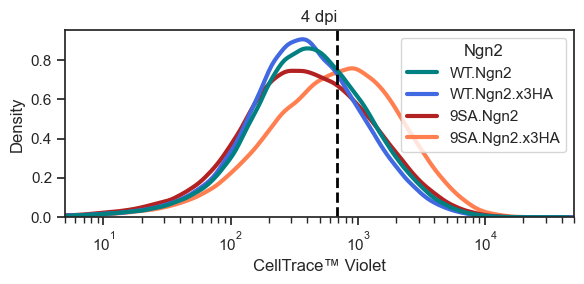

In [10]:
sns.set_theme(style="ticks",font_scale=1)

order = ['WT.Ngn2','WT.Ngn2.x3HA','9SA.Ngn2','9SA.Ngn2.x3HA']

palette = {'Puro':'black',
           'NIL':'grey',
           '9SA.Ngn2':'firebrick',
           '9SA.Ngn2.x3HA':'coral',
           'WT.Ngn2':'teal',
           'WT.Ngn2.x3HA':'royalblue'}

slice = df[(df['rep'] == 'A') & (df['infection']=='NIL RIDD') & (df['small molecule'] == 'none')]
display(slice.Ngn2.unique())

fig = plt.figure(figsize=(6,3))
g = sns.kdeplot(data=slice,x='CTV-A',hue='Ngn2',log_scale=True,common_norm=False,linewidth=3,palette=palette,hue_order=order)
plt.axvline(x=CTV_gates['A'],linestyle='--',color='black',linewidth=2)

#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
plt.xlim([5,5*10**4])
plt.title('4 dpi')
plt.xlabel('CellTrace™ Violet')
fig.tight_layout()
plt.show()

In [11]:
groups = ['rep','Ngn2','infection','small molecule','condition','condition2','well'] # 'rep' must be first group!!!!


def percent_hyperP(x):
    rep = x.name[0]  # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.mean(x < gate_value) * 100

def total_hyperP(x):
    rep = x.name[0]  # Assuming 'rep' is the first group
    gate_value = CTV_gates[rep]
    return np.sum(x < gate_value)

# Create the summary dataframe
summary_df = pd.concat([
    df.groupby(groups)['CTV-A'].apply(percent_hyperP).rename('(%) HyperP'),
    df.groupby(groups)['CTV-A'].apply(total_hyperP).rename('(#) Total HyperP'),
    df.groupby(groups)['CTV-A'].apply(lambda x: np.size(x)).rename('Total Cell Count'),
], axis=1)
summary_df = summary_df.reset_index()

data2plot = ['(%) HyperP','(#) Total HyperP','Total Cell Count']

# Plotting Functions

In [12]:
def custom_barplot(x,y,data,filename,height=4,width=8,hue=None,
                   xlabel_rot=90,xlabel='',plottitle='',palette='viridis',
                   order=None,hue_order=None,pairs=None,alpha=0.8,reps=None,hlines=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X','*']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    if hlines:
        for h in hlines:
            plt.axhline(y=h, color='#cccccc', linestyle='--',zorder=-1)

    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)



def custom_catplot(xcat,ycat,dataslice,savetitle,height=4,width=8,xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None):
    if palette != None:
        hue = xcat
        color = None
    elif palette == None:
        hue = None
        color = '#000000'
    aspect = width / height
    g = sns.catplot(x=xcat,y=ycat,data=dataslice,height=height,aspect=aspect,zorder=1,palette=palette,order=order,hue=hue,color=color,s=70)
    g.map_dataframe(sns.pointplot, x=xcat,y=ycat,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    #sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,ax=g.ax,palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color)
    ax = plt.gca()
    
    #plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))  # this is for if you want scientific y axis labels (e.g. 10^4 instead of 10000)
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if pairs != None:
        annotator = Annotator(g.ax,pairs,data=dataslice,x=xcat,y=ycat,order=order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

    #sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    g.tight_layout()
    plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    
    g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)

def custom_hist(xcat,data,order,hue,savetitle=None,palette='muted',gate=None,xlim=[10,5*10**4]):
    plt.figure(figsize=(8,4))
    if xcat in ['FSC-A','FSC-H']:
        log = False
        plt.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    else:
        log = True
    g = sns.kdeplot(data=data,x=xcat,hue=hue,log_scale=log,common_norm=False,hue_order=order,palette=palette, linewidth=2.5,fill=True,alpha=0.08)

    if gate is not None:
        plt.axvline(x=gate,linestyle='--',color='black',linewidth=2.5)

    sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.xlim(xlim)
    plt.title('4 dpi')
    plt.xlabel(xcat)
    plt.tight_layout()
    #g.savefig(outputdir/str(savetitle + '.png'),dpi=300)
    g.savefig(outputdir/str(savetitle + '.svg'),dpi=300)


# Plot Results

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.918e-10 t=8.754e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.316e-09 t=7.395e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:3.238e-22 t=2.014e+01
NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.351e-13 t=1.094e+01
NIL RIDD, MEKi_WT.Ngn2.x3HA vs. NIL RIDD, MEKi_9SA.Ngn2.x3HA: t-test independent samples, P_val:4.554e-07 t=6.103e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-te

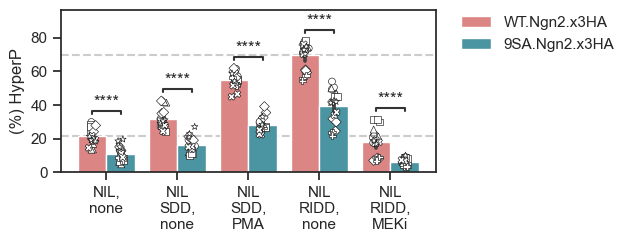

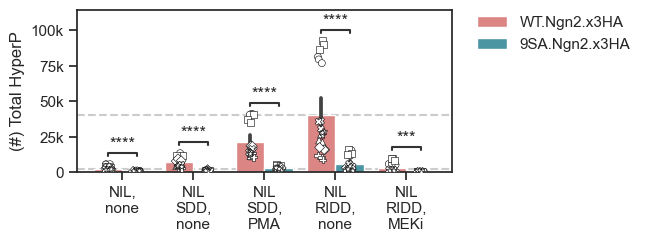

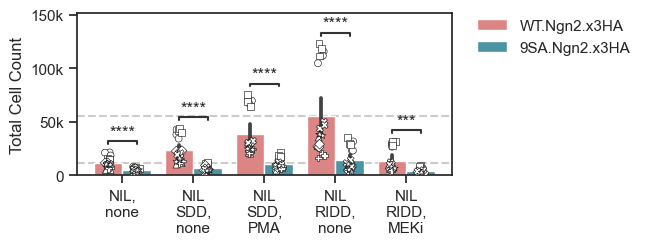

In [13]:
reps2plot = ['A', 'B','C','D','E','F','G']
dataslice = summary_df[summary_df['rep'].isin(reps2plot)]

palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL, none',
         'NIL SDD, none','NIL SDD, PMA',
         'NIL RIDD, none', 'NIL RIDD, MEKi',]

pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, none','WT.Ngn2.x3HA'),('NIL SDD, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, PMA','WT.Ngn2.x3HA'),('NIL SDD, PMA','9SA.Ngn2.x3HA')),
         (('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA')),
         (('NIL RIDD, MEKi','WT.Ngn2.x3HA'),('NIL RIDD, MEKi','9SA.Ngn2.x3HA')),]


for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = i + '_Ngn2x3HA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=5,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])


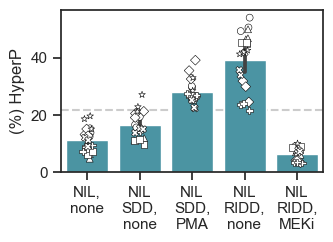

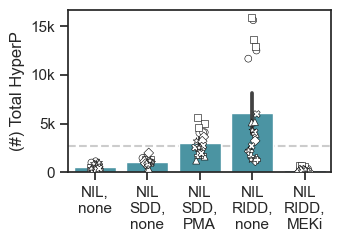

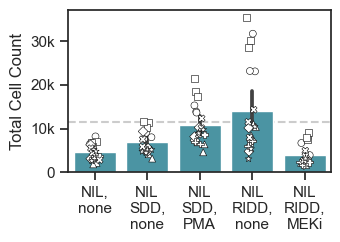

In [14]:
order = ['NIL, none',
         'NIL SDD, none','NIL SDD, PMA',
         'NIL RIDD, none', 'NIL RIDD, MEKi',]

for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = i + '_Ngn2x3HA_9SA'
    custom_barplot('condition2',i,dataslice[dataslice.Ngn2=='9SA.Ngn2.x3HA'],savetitle,
                    order = order,
                    palette=sns.color_palette(['#3d9eb0','#3d9eb1']),
                    height=2.5,
                    width=3.5,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',hlines=[NIL_hline])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.351e-13 t=1.094e+01
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.316e-09 t=7.395e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:7.412e-06 t=5.147e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.905e-07 t=5.931e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL R

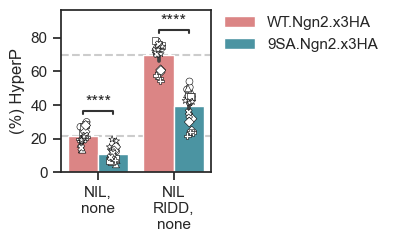

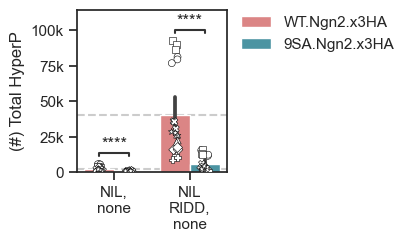

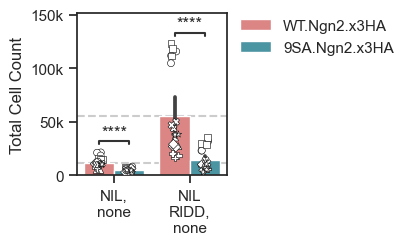

In [15]:
palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL, none',
         'NIL RIDD, none']


pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA'))]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = i + '_Ngn2x3HA_PMA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=2,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.918e-10 t=8.754e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.316e-09 t=7.395e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent samples, P_val:3.238e-22 t=2.014e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL SDD, none_WT.Ngn2.x3HA vs. NIL SDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:4.124e-09 t=7.694e+00
NIL, none_WT.Ngn2.x3HA vs. NIL, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:5.905e-07 t=5.931e+00
NIL SDD, PMA_WT.Ngn2.x3HA vs. NIL SDD, PMA_9SA.Ngn2.x3HA: t-test independent

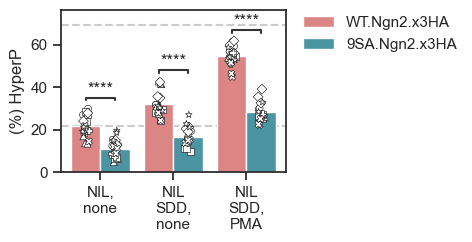

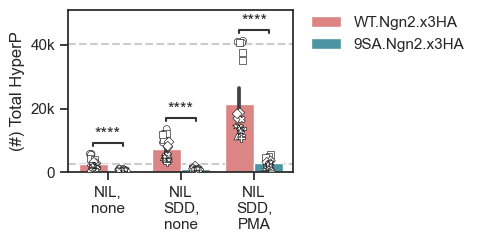

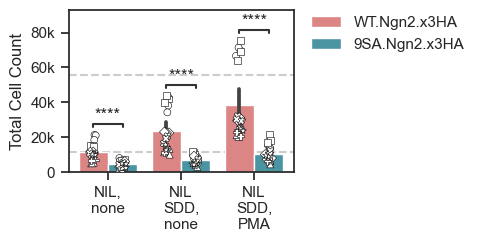

In [16]:
order = ['NIL, none',
         'NIL SDD, none','NIL SDD, PMA']


pairs = [(('NIL, none','WT.Ngn2.x3HA'),('NIL, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, none','WT.Ngn2.x3HA'),('NIL SDD, none','9SA.Ngn2.x3HA')),
         (('NIL SDD, PMA','WT.Ngn2.x3HA'),('NIL SDD, PMA','9SA.Ngn2.x3HA'))]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = i + '_Ngn2x3HA_PMA'
    custom_barplot('condition2',i,dataslice,savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:1.351e-13 t=1.094e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:7.412e-06 t=5.147e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL RIDD, none_WT.Ngn2.x3HA vs. NIL RIDD, none_9SA.Ngn2.x3HA: t-test independent samples, P_val:2.695e-05 t=4.741e+00


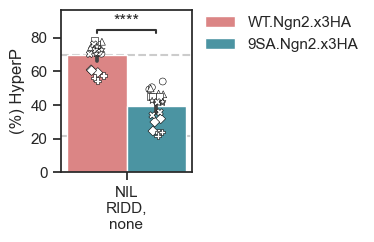

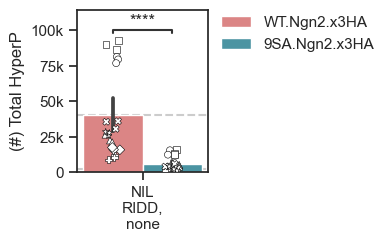

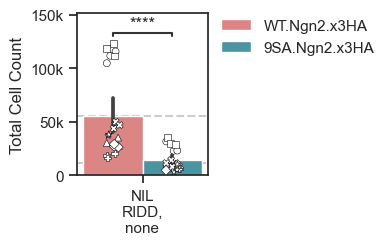

In [17]:
palette = {'WT.Ngn2.x3HA':'#ea7676','9SA.Ngn2.x3HA':'#3d9eb0'}

order = ['NIL RIDD, none']


pairs = [(('NIL RIDD, none','WT.Ngn2.x3HA'),('NIL RIDD, none','9SA.Ngn2.x3HA'))]
for i in data2plot:
    NIL_hline = np.mean(dataslice[(dataslice['condition2']=='NIL, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    RIDD_hline =  np.mean(dataslice[(dataslice['condition2']=='NIL RIDD, none') & (dataslice['Ngn2']=='WT.Ngn2.x3HA')][i])
    savetitle = 'RIDD-only_' + i + '_Ngn2x3HAA'
    custom_barplot('condition2',i,dataslice[dataslice.condition2.isin(order)],savetitle,
                    order = order,
                    hue = 'Ngn2',
                    hue_order=['WT.Ngn2.x3HA','9SA.Ngn2.x3HA'],
                    palette=palette,
                    height=2.5,
                    width=1.75,
                    xlabel_rot=0,
                    alpha=1,
                    reps='rep',pairs=pairs,hlines=[NIL_hline,RIDD_hline])
